# Example Notebook for BHPTNRSur1dq1e4

### Goal: Comparison with an NR Surrogate model NRHybSur3dq8

This notebook will provide some comparisons between the BHPTNRSur1dq1e4 and NRHybSur3dq8 models that appear in the [arXiv paper](https://arxiv.org/abs/2204.01972).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gwtools
from gwtools.gwtools import minimize_norm_error_multi_mode
from gwtools.mismatch import mathcal_E_error_from_mode_dict
# we use NR surrogate models as a proxy for NR
import gwsurrogate
# we use aligned spin model in its non-spinning limit
nrsur = gwsurrogate.LoadSurrogate('NRHybSur3dq8')
import sys
# add the path to the script directory
# provide the path to the BHPTNRSurrogate directory
PATH_TO_BHPTNRSur = "/data/tislam/git/BHPTNRSurrogate"
#PATH_TO_BHPTNRSur = "/home/balzani57/Repo/GitRepos/Codes/BHPTNRSurrogate"
sys.path.append(PATH_TO_BHPTNRSur+"/surrogates")
import BHPTNRSur1dq1e4 as bhptsur

/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work
Loaded NRHybSur3dq8 model


## 1. Inspect the BHPTNRSur1dq1e4 model-calibration parameters

By default, the BHPTNRSurrogate package will return rescaled waveform modes,
$$
\begin{align}
h^{\ell,m}_{\tt S, \alpha}(t ; q)= {\alpha_{\ell}} h^{\ell,m}_{\tt S}\left( t \beta;q \right) \,,
\end{align}
$$
where the calibration parameters, $\alpha_{\ell}(q)$ and $\beta(q)$, are tuned to NR simulations.

Lets first check that the values provided with the BHPTNRSurrogate package matches table 2 in [the paper](https://arxiv.org/abs/2204.01972)

In [2]:
import pprint
pprint.pprint(bhptsur.alpha_coeffs)
print(bhptsur.beta_coeffs)

{(2, 2): array([-1.33017444,  2.72014993, -5.90434962,  5.54892443]),
 (3, 3): array([-3.06706275,  6.24429278, -9.94465613,  6.43708662]),
 (4, 4): array([ -3.90936954,   9.43175437, -14.73467817,   9.74448568]),
 (5, 5): array([ -4.50942546,   4.75170693,  21.95951111, -52.35084736])}
[-1.23847207  1.59677397 -1.77656059  1.05778279]


## 2. Compare BHPTNRSur1dq1e4 and NRHybSur3dq8 at mass ratio q=4

This comparison will reproduce the right column of figure 8 from [the paper](https://arxiv.org/abs/2204.01972)

dict_keys([(2, 2), (2, -2), (2, 1), (2, -1), (3, 1), (3, -1), (3, 2), (3, -2), (3, 3), (3, -3), (4, 2), (4, -2), (4, 3), (4, -3), (4, 4), (4, -4), (5, 3), (5, -3), (5, 4), (5, -4), (5, 5), (5, -5)])


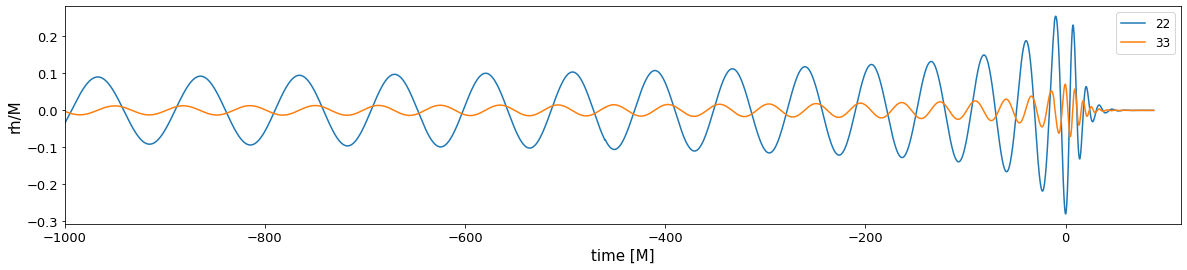

In [3]:
# Evaluate the BHPTNRSur1dq1e4 model

tsur, hsur = bhptsur.generate_surrogate(q=4, calibrated=True)

print(hsur.keys())

plt.figure(figsize=(20,4))
plt.plot(tsur, np.real(hsur[(2,2)]), '-', label='22')
plt.plot(tsur, np.real(hsur[(3,3)]), '-', label='33')
plt.xlim(-1000,115)
plt.xlabel('time [M]', fontsize=15)
plt.ylabel('rh/M', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=12)
plt.show()

In [4]:
# convience wrapper for calling the NRHybSur3dq8 model
def generate_nrsur(q_input, f_low=None, t_start=None):
    chiA = [0, 0, 0.0]
    chiB = [0, 0, 0.0]
    dt = 0.1        # step size, Units of M
    if f_low==None:
        f_low=5e-3
    if t_start==None:
        t_start=-5000.1
    # dyn stands for dynamics and is always None for this model
    t, h, dyn = nrsur(q_input, chiA, chiB, dt=dt, f_low=f_low) 
    # we only take the last 5000M long waveform to calibrate
    indx = np.where(t>=t_start)
    t = t[indx]
    for mode in h.keys():
        h[mode] = h[mode][indx]
    return t,h

In [5]:
# Evaluate the NRHybSur3dq8 model
tnr, h_NRHybSur3dq8 = generate_nrsur(q_input=4)

# remove the (2,0) and (3,0) modes from NRHybSur3dq8 (these are not included in the BHPTNRSur1dq1e4 model)
h_NRHybSur3dq8.pop((2,0))
h_NRHybSur3dq8.pop((3,0))

# Evaluate the BHPTNRSur1dq1e4 model for NRHybSur3dq8's modes
tsur, h_BHPTKSur = bhptsur.generate_surrogate(q=4, modes=h_NRHybSur3dq8.keys(), calibrated=True, neg_modes=False)


# for demonstration, we will match three representative modes
modelist = [(2,2),(3,3),(4,4)]

# multi-modal match
[errors_before_min, errors_after_min], [tc, phic], [common_times,h_bhpt_aligned,h_nr_aligned] = \
                            minimize_norm_error_multi_mode(tsur, h_BHPTKSur, tnr, h_NRHybSur3dq8, mode_list=None, ell_m_match=(2,2),\
                                    t_low_adj=0,t_up_adj=0,method='nelder-mead')

Performing a physical rotation by pi...


In [6]:
# compute error in each mode -- These are the values CalE_{IMR} shown in each figure
for mode in modelist:
    tmp = gwtools.mismatch.mathcal_E_error_from_mode_list(h_nr_aligned[mode],h_bhpt_aligned[mode])
    print("mode (%i, %i) error = %f"%(mode[0],mode[1], tmp))

# compute error in each mode weighted by full multi-modal norm (Eq 21; https://arxiv.org/pdf/1701.00550.pdf)
# This shows that an error of 0.026 in the (4,4) mode (see above) is alternatively understood as an 
# error of 4e-5 then we consider the full waveform in the time-domain. 
relative_mode_errors = gwtools.mismatch.mathcal_E_mode_contributions_from_mode_dict(h_nr_aligned,h_bhpt_aligned)
pprint.pprint(relative_mode_errors)

mode (2, 2) error = 0.001299
mode (3, 3) error = 0.006326
mode (4, 4) error = 0.025948
{(2, 1): 0.001763871388118208,
 (2, 2): 0.001262176920948561,
 (3, 1): 1.233698240740912e-05,
 (3, 2): 9.443156532323067e-05,
 (3, 3): 0.00012880086271003876,
 (4, 2): 2.4550099027041833e-06,
 (4, 3): 1.8301039012590375e-05,
 (4, 4): 4.1483106134878104e-05,
 (5, 5): 8.580830694632284e-06}


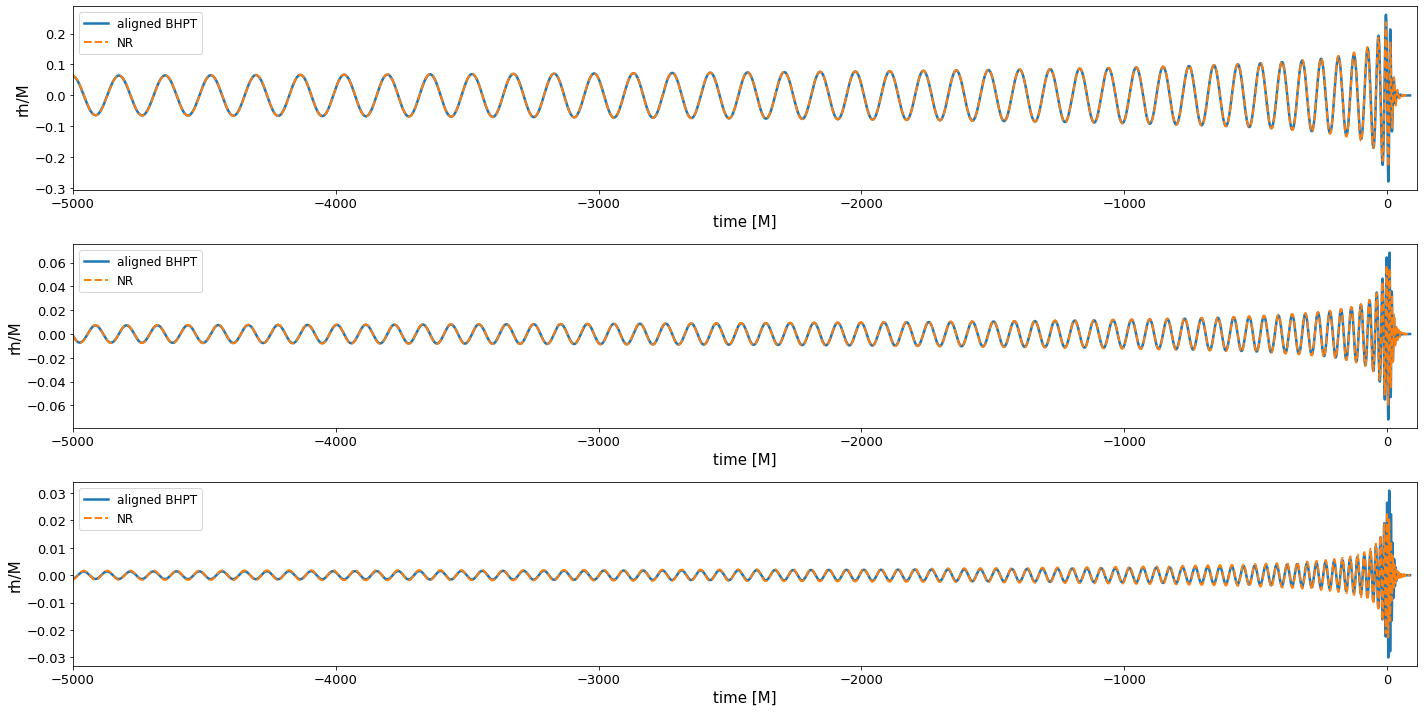

In [7]:
plt.figure(figsize=(20,10))

plt.subplot(311)
plt.plot(common_times, np.real(h_bhpt_aligned[(2,2)]), '-', lw=2.5, label='aligned BHPT')
plt.plot(common_times, np.real(h_nr_aligned[(2,2)]), '--', lw=2.0, label='NR')
plt.xlim(-5000,115)
plt.xlabel('time [M]', fontsize=15)
plt.ylabel('rh/M', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=12)

plt.subplot(312)
plt.plot(common_times, np.real(h_bhpt_aligned[(3,3)]), '-', lw=2.5, label='aligned BHPT')
plt.plot(common_times, np.real(h_nr_aligned[(3,3)]), '--', lw=2.0, label='NR')
plt.xlim(-5000,115)
plt.xlabel('time [M]', fontsize=15)
plt.ylabel('rh/M', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=12)

plt.subplot(313)
plt.plot(common_times, np.real(h_bhpt_aligned[(4,4)]), '-', lw=2.5, label='aligned BHPT')
plt.plot(common_times, np.real(h_nr_aligned[(4,4)]), '--', lw=2.0, label='NR')
plt.xlim(-5000,115)
plt.xlabel('time [M]', fontsize=15)
plt.ylabel('rh/M', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## 3. Compare BHPTNRSur1dq1e4 and NRHybSur3dq8 for $3 \leq q \leq 10$ 

This comparison will reproduce figure 7 from [the paper](https://arxiv.org/abs/2204.01972)

In [8]:
from tqdm import tqdm
    
qs = np.linspace(3,10,50)
mode_errors = {(2,2):[],(3,3):[],(4,4):[]}

for q in tqdm(qs):
    
    # Evaluate the NRHybSur3dq8 model
    tnr, h_NRHybSur3dq8 = generate_nrsur(q_input=q)

    # remove the (2,0) and (3,0) modes from NRHybSur3dq8 (these are not included in the BHPTNRSur1dq1e4 model)
    h_NRHybSur3dq8.pop((2,0))
    h_NRHybSur3dq8.pop((3,0))

    # Evaluate the BHPTNRSur1dq1e4 model for NRHybSur3dq8's modes
    tsur, h_BHPTKSur = bhptsur.generate_surrogate(q=q, modes=h_NRHybSur3dq8.keys(), calibrated=True, neg_modes=False)

    # multi-modal match
    [errors_before_min, errors_after_min], [tc, phic], [common_times,h_bhpt_aligned,h_nr_aligned] = \
                            minimize_norm_error_multi_mode(tsur, h_BHPTKSur, tnr, h_NRHybSur3dq8, mode_list=None, ell_m_match=(2,2),\
                                    t_low_adj=0,t_up_adj=0,method='nelder-mead')
    for mode in modelist:
        mode_errors[mode].append( gwtools.mismatch.mathcal_E_error_from_mode_list(h_nr_aligned[mode],h_bhpt_aligned[mode]) )

  4%|▍         | 2/50 [00:02<01:10,  1.47s/it]

Performing a physical rotation by pi...


  6%|▌         | 3/50 [00:04<01:09,  1.48s/it]

Performing a physical rotation by pi...


 10%|█         | 5/50 [00:07<01:05,  1.46s/it]

Performing a physical rotation by pi...


 16%|█▌        | 8/50 [00:11<01:00,  1.44s/it]

Performing a physical rotation by pi...


 20%|██        | 10/50 [00:14<00:57,  1.43s/it]

Performing a physical rotation by pi...


 22%|██▏       | 11/50 [00:15<00:55,  1.42s/it]

Performing a physical rotation by pi...


 26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

Performing a physical rotation by pi...


 32%|███▏      | 16/50 [00:22<00:48,  1.42s/it]

Performing a physical rotation by pi...


 36%|███▌      | 18/50 [00:25<00:45,  1.42s/it]

Performing a physical rotation by pi...


 42%|████▏     | 21/50 [00:30<00:41,  1.42s/it]

Performing a physical rotation by pi...


 46%|████▌     | 23/50 [00:32<00:38,  1.42s/it]

Performing a physical rotation by pi...


 52%|█████▏    | 26/50 [00:37<00:35,  1.46s/it]

Performing a physical rotation by pi...


 56%|█████▌    | 28/50 [00:40<00:31,  1.44s/it]

Performing a physical rotation by pi...


 62%|██████▏   | 31/50 [00:44<00:27,  1.44s/it]

Performing a physical rotation by pi...


 66%|██████▌   | 33/50 [00:47<00:24,  1.45s/it]

Performing a physical rotation by pi...


 70%|███████   | 35/50 [00:50<00:21,  1.45s/it]

Performing a physical rotation by pi...


 72%|███████▏  | 36/50 [00:51<00:20,  1.44s/it]/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=8.1429 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
 74%|███████▍  | 37/50 [00:53<00:18,  1.45s/it]/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=8.2857 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
 76%|███████▌  | 38/50 [00:54<00:17,  1.45s/it]

Performing a physical rotation by pi...


/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=8.4286 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
 78%|███████▊  | 39/50 [00:56<00:16,  1.46s/it]/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=8.5714 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
 80%|████████  | 40/50 [00:57<00:14,  1.47s/it]

Performing a physical rotation by pi...


/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=8.7143 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
 82%|████████▏ | 41/50 [00:59<00:13,  1.46s/it]/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=8.8571 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
 84%|████████▍ | 42/50 [01:00<00:11,  1.46s/it]

Performing a physical rotation by pi...


/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=9.0000 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
 86%|████████▌ | 43/50 [01:02<00:10,  1.47s/it]/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=9.1429 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
 88%|████████▊ | 44/50 [01:03<00:08,  1.47s/it]/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=9.2857 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
 90%|█████████ | 45/50 [01:04<00:07,  1.47s/it]

Performing a physical rotation by pi...


/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=9.4286 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
 92%|█████████▏| 46/50 [01:06<00:05,  1.47s/it]/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=9.5714 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
 94%|█████████▍| 47/50 [01:07<00:04,  1.48s/it]

Performing a physical rotation by pi...


/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=9.7143 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
 96%|█████████▌| 48/50 [01:09<00:02,  1.47s/it]/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=9.8571 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
 98%|█████████▊| 49/50 [01:10<00:01,  1.48s/it]

Performing a physical rotation by pi...


/opt/jupyter-hub/anaconda3/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0000 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
100%|██████████| 50/50 [01:12<00:00,  1.45s/it]


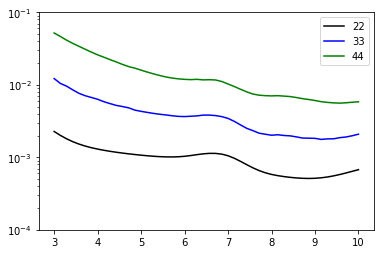

In [9]:
# IMR errors for different modes as a function of mass ratio
# This figure can be compared with figure 7 (https://arxiv.org/pdf/2204.01972.pdf)
plt.semilogy(qs,mode_errors[(2,2)],'k',label='22')
plt.semilogy(qs,mode_errors[(3,3)],'b',label='33')
plt.semilogy(qs,mode_errors[(4,4)],'g',label='44')
plt.ylim([1e-4,1e-1])
plt.legend()